In [1]:
from time import time

import lightning as L
import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import torch
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from torch.optim import Adam

from NCP.examples.tools.plot_utils import setup_plots
from NCP.metrics import kolmogorov_smirnov, smooth_cdf
from NCP.model import NCPModule, NCPOperator

#import normflows as nf
# diffusion model imports:
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.nn.nf_module import NFModule
from NCP.utils import FastTensorDataLoader, from_np

setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NEXP = 1

In [2]:
# Common optimizer
lr = 1e-3

optimizer = Adam
optimizer_kwargs = {
        'lr': lr
        }

In [10]:
from sklearn.preprocessing import StandardScaler

N = 50000
d = 100

from scipy.stats import special_ortho_group as sog

H = sog.rvs(d)

def multinom(q):
    return np.sum(np.random.multinomial(1, q) * np.array([1., 2., 3., 4., 5.]))

def create_manifold_dataset(N, noise, rng=None):

    thetas = np.random.uniform(0, 2*np.pi, N)

    X_low_dim = np.concatenate([np.cos(thetas).reshape(-1,1), np.sin(thetas).reshape(-1, 1)], axis=-1)

    if noise:
        X_low_dim * np.random.uniform(-1.5, 1, N)
    X = np.concatenate([X_low_dim, np.zeros((N, d-2))], axis=-1) @ H

    Y = np.zeros((X.shape[0], 1))
    for i, xi in enumerate(X):
        if thetas[i] < np.pi/2:
            Y[i] = multinom([1/5]*5)
        elif thetas[i] < np.pi:
            Y[i] = multinom([0.5, 0.5, 0, 0, 0])
        elif thetas[i] < 3*np.pi/2:
            Y[i] = multinom([0, 0, 1, 0., 0])
        else:
            Y[i] = multinom([0, 0, 0, 0.5, 0.5])
    Y = Y.reshape((-1,1))

    return X,Y, thetas

In [11]:
noisy=False

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, Y_train, thetas_train = create_manifold_dataset(Ntrain, noisy)
X_val, Y_val, thetas_val = create_manifold_dataset(Nval, noisy)
X_test, Y_test, thetas_test = create_manifold_dataset(Ntest, noisy)

X_train_torch = from_np(X_train)
Y_train_torch = from_np(Y_train)
X_val_torch = from_np(X_val)
Y_val_torch = from_np(Y_val)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

In [29]:
best_models = {}
times_ncp = np.zeros(NEXP)

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 1e-4
    epochs = int(1e3)
    output_shape = 800

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 7,
        'layer_size': 258,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 7,
        'layer_size':258,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.ReLU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    #early_stop = EarlyStopping(monitor="val_loss", patience=500, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback])

    start_time = time()
    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    times_ncp[exp] = time()-start_time

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

    del NCP_module
    del reg

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, v_num=438, val_loss=-1.48, train_loss=-1.51]      

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s, v_num=438, val_loss=-1.48, train_loss=-1.51]


In [30]:
best_models_nf = {}
times_nf = np.zeros(NEXP)

for exp in range(NEXP):
    L.seed_everything(exp)

    base = nf.distributions.base.DiagGaussian(1)

    num_flows = 2
    latent_size = 1
    hidden_units = 128
    num_blocks = 3
    flows = []
    for i in range(num_flows):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, num_blocks, hidden_units,
                                                    num_context_channels=X_train.shape[-1])]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # If the target density is not given
    model = nf.ConditionalNormalizingFlow(base, flows)

    nf_module = NFModule(model,
        optimizer,
        optimizer_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(5e2),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])

    start_time = time()
    trainer.fit(nf_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
    times_nf[exp] = time()-start_time

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    nf_module.load_state_dict(best_model_dict['state_dict'])

    best_models_nf[exp] = nf_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s, v_num=439, val_loss=-0.337, train_loss=-0.692]   

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s, v_num=439, val_loss=-0.337, train_loss=-0.692]


In [31]:
# todo: plot different cdfs, replicate plots from linCDE

def manifold_cdf(theta, fys):
    if theta < np.pi/2:
        return ((fys > 1).astype(int) + (fys > 2).astype(int) + (fys > 3).astype(int) + (fys > 4).astype(int) + (fys > 5).astype(int))/5
    elif theta < np.pi:
        return 0.5*(fys > 1).astype(int) + 0.5*(fys > 2).astype(int)
    elif theta < 3*np.pi/2:
        return  (fys > 3).astype(int)
    else:
        return ((fys > 4).astype(int) + (fys > 5).astype(int))/2

def get_emp_dist(discr_data, ys):
    support = list(set(list(discr_data.flatten())))
    p = np.zeros(ys.shape[0])
    j = 0
    for i, y in enumerate(ys):
        if y >= support[j]:
            p[i] = np.sum((discr_data == support[j]))/discr_data.shape[0]
            j += 1
        if j == len(support):
            break
    return p

def get_pdf_from_nf(model:nf.ConditionalNormalizingFlow, x, ys):
    # since only one x, duplicate
    xs = x.repeat(ys.size()[0], 1)
    log_prob = model.log_prob(ys, xs).detach().cpu().numpy()
    return np.exp(log_prob)

def get_cdf_from_nf(model:nf.ConditionalNormalizingFlow, x, ys):
    # supposing that ys is computed from linspace
    prob = get_pdf_from_nf(model, x, torch.Tensor(ys))
    ys_bis = ys.numpy().flatten()
    return np.concatenate([[0], np.cumsum(prob[1:])*(ys_bis[1:] - ys_bis[:-1])])

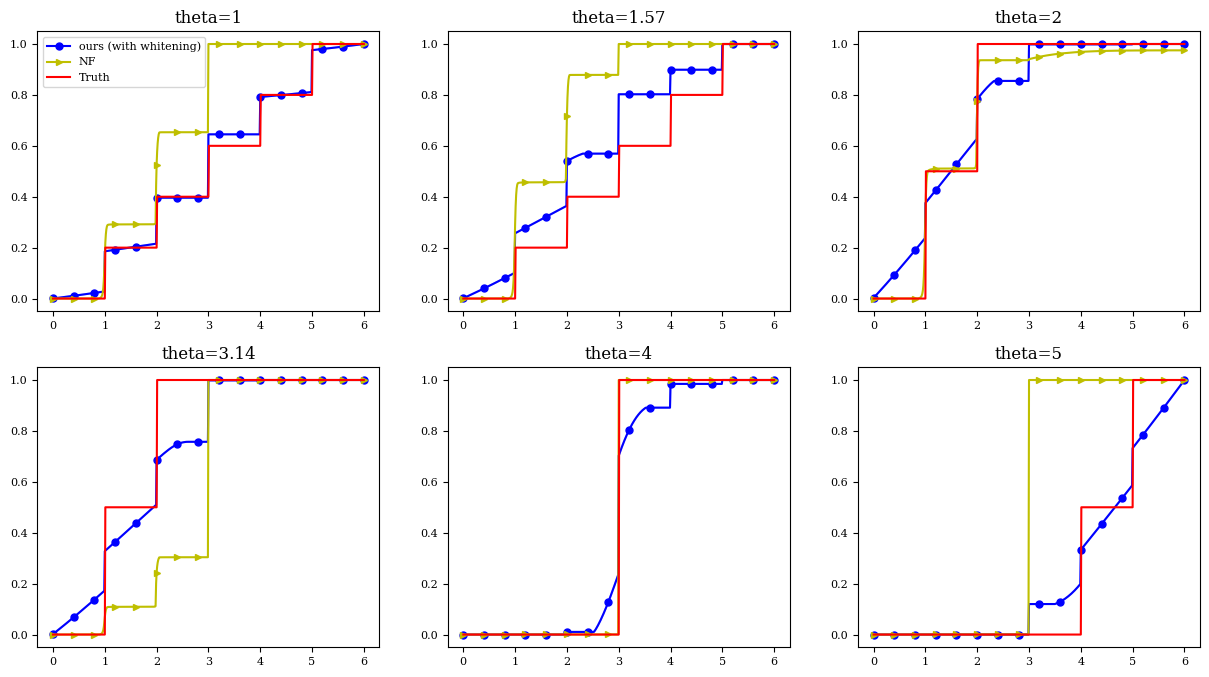

In [32]:
#x1 = np.linspace(np.min(thetas_test), np.max(thetas_test), 9) # mean
x1 = [1, 1.57, 2, 3.14, 4, 5]

p1, p99 = 0, 6
y_discr, step = np.linspace(p1, p99, num=601, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

probas = get_emp_dist(Y_test, y_discr)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
axes = ax.flatten()

ks_dist_ncp = np.zeros((len(x1), NEXP))
ks_dist_nf = np.zeros((len(x1), NEXP))

for i, xi in enumerate(x1):
    x = np.array([np.cos(xi), np.sin(xi)])
    x_scaled = torch.Tensor([np.concatenate([x, np.zeros((d-2))]) @ H])

    our_cdfs = np.zeros((NEXP, y_discr.shape[0]))
    nf_cdfs = np.zeros((NEXP, y_discr.shape[0]))

    for exp in range(NEXP):
        ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, probas=probas, postprocess='whitening')
        our_cdfs[exp] = smooth_cdf(ys, cdf_pred_center)

        fys = ys.copy()

        nf_cdfs[exp] = get_cdf_from_nf(best_models_nf[exp], x_scaled, y_discr_torch)

    true_cdf = manifold_cdf(xi, fys)
    axes[i].plot(fys, our_cdfs.mean(axis=0), '-ob', label='ours (with whitening)', markevery=40, markersize=5)
    for exp in range(NEXP):
        axes[i].plot(fys, our_cdfs[exp], '-b', alpha=0.2)

    axes[i].plot(fys, np.minimum(nf_cdfs.mean(axis=0), 1), '->y', label='NF',markevery=40, markersize=5)

    axes[i].plot(fys, true_cdf, 'r', label='Truth')

    if i==0:
        axes[i].legend()

    axes[i].set_title(f'theta={round(xi, 3)}')


    for exp in range(NEXP):
        #print(np.isnan(nf_cdfs[exp]).sum())
        ks_dist_ncp[i, exp] = kolmogorov_smirnov(true_cdf, our_cdfs[exp], values=fys)
        ks_dist_nf[i, exp] = kolmogorov_smirnov(true_cdf, nf_cdfs[exp], values=fys)

In [9]:
df.to_csv()

NameError: name 'df' is not defined